### Data Augmentation

In this notebook data augmentation is performed for improving the performances of the ConvLSTM model. 

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

c:\Users\anton\OneDrive\Desktop\TU Delft\Q6\Data Science and Artificial Intelligence for Engineers\FLOOD_group2\models
c:\Users\anton\OneDrive\Desktop\TU Delft\Q6\Data Science and Artificial Intelligence for Engineers\FLOOD_group2


In [2]:
import importlib
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

# import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.ConvLSTM_pytorch.multistep_convlstm import MultiStepConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from pre_processing.augmentation import *
from post_processing.cool_animation import plot_animation
from post_processing.plots import *

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/conv_lstm_4batch_16hidden_3kernel_augmentation.pth'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
# # From FAT application
# fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# # specify which entry of the dataset to plot
# numb = 0
# inputs = train_dataset[numb][0][0]

# axs[0].imshow(inputs[0].cpu(), cmap='terrain', origin='lower')
# axs[0].set_title('DEM')

# axs[1].imshow(inputs[1].cpu(), cmap='RdBu', origin='lower')
# axs[1].set_title('Slope X')

# axs[2].imshow(inputs[2].cpu(), cmap='RdBu', origin='lower')
# axs[2].set_title('Slope Y')

# non_zero_indices = torch.nonzero(inputs[3].cpu())
# non_zero_row, non_zero_col = non_zero_indices[0][0].item(), non_zero_indices[0][1].item()
# axs[3].imshow(inputs[3].cpu(), cmap='binary', origin='lower')
# axs[3].set_title('Breach Location')
# axs[3].scatter(non_zero_col, non_zero_row, color='k', marker='x', s=100,
#                 clip_on = False, clip_box = plt.gca().transData)
# plt.show()

In [8]:
def augmentation(train_dataset, range_t, p_hflip=0.5, p_vflip=0.5, full=True):
    '''
    Function for implementing data augmentation of inputs (DEM, X- and Y-Slope,
    Water Depth, and Discharge).

    Input: train_dataset = torch tensor, dataset with input variables
           p_hflip, p_vflip = float, probability of horizontal and vertical flipping
                              default = 0.5 for both
           angles = angle degrees for dataset rotation, fixed at 0°, 90°, 180°, 270°
    Output:
    '''
    # Define the transformation pipeline with horizontal and vertical flip
    transformation_pipeline = transforms.Compose([
        transforms.RandomHorizontalFlip(p=p_hflip),
        transforms.RandomVerticalFlip(p=p_vflip)])

    # Apply the transformation to each sample in the original dataset
    transformed_samples = [transformation_pipeline(sample) for sample in train_dataset]

    # Unpack the tuples and create a new dataset with the transformed samples
    transformed_tensors = [torch.stack(sample) for sample in zip(*transformed_samples)]
    transformed_dataset = torch.utils.data.TensorDataset(*transformed_tensors)

    # Concatenate the original dataset and the transformed dataset
    full_dataset = torch.utils.data.ConcatDataset([train_dataset, transformed_dataset])

    # Print the shapes of datasets
    # print(f"Shape of train_dataset: {np.shape(train_dataset)}")
    # print(f"Shape of transformed_dataset: {np.shape(transformed_dataset)}")
    # print(f"Shape of full_dataset: {np.shape(full_dataset)}")

    return full_dataset if full else transformed_dataset

In [9]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_wd, scaler_q = scaler(train_dataset)

normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_wd, scaler_q, train_val)

In [10]:
transformed_dataset = augmentation(normalized_train_dataset, range_t=len(normalized_train_dataset), p_hflip=0.5, p_vflip=0.5, full=True)

In [11]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_set, val_set = random_split(transformed_dataset, [train_size, val_size])

In [12]:
# Model
model = ConvLSTM(input_dim = train_set[0][0].shape[1], output_dim = train_set[0][1].shape[1], hidden_dim = 16, kernel_size = (3, 3),
                 num_layers = 48, batch_first=True, bias=True, return_all_layers = True).to(device)
# return all layers has to be true to obtain all the outputs I think
# num_layers refers to the number of cells and thus outputs
# Number of outputs = 4 gates * hidden_dim

In [13]:
model

ConvLSTM(
  (conv2): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-47): 47 x ConvLSTMCell(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [14]:
# Set training parameters
learning_rate = 0.001
batch_size = 4 # Only have 64 and 16 samples for training and validation, I think should be kept small, having issues where this only works if set to 1
num_epochs = 50

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [15]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluation_conv_lstm(model, val_loader, device=device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch%10 == 0:
        print(f"epoch: {epoch} \t training loss: {train_loss: .2e} \t validation loss: {val_loss: .2e}")

epoch: 10 	 training loss:  3.52e-03 	 validation loss:  3.39e-03
epoch: 20 	 training loss:  3.50e-03 	 validation loss:  3.37e-03
epoch: 30 	 training loss:  3.49e-03 	 validation loss:  3.36e-03
epoch: 40 	 training loss:  3.37e-03 	 validation loss:  3.22e-03
epoch: 50 	 training loss:  3.07e-03 	 validation loss:  2.99e-03


In [16]:
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

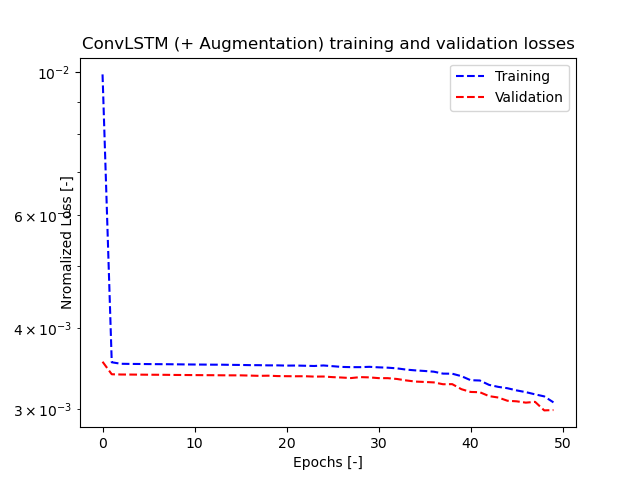

In [17]:
plot_losses(train_losses, val_losses, 'ConvLSTM (+ Augmentation) ')

In [18]:
# plot_animation(10, normalized_train_dataset, model, train_val,
#                scaler_x, scaler_wd, scaler_q, device = device, save = False)

In [152]:
def plot_sorted(dataset, train_val, scaler_x, scaler_wd, scaler_q, model, device):
    '''
    Function for plotting the DEMs variation sorted in increasing order 
    of average loss (of Water Depth and Discharge)

    Input: dataset = tensor, normalized dataset
           train_val_test : str, Identifier of dictionary. Expects: 'train_val', 'test1', 'test2', 'test3'.
           scaler_x, scaler_wd, scaler_q = scalers for inputs (x) and targets (water depth and discharge), created 
                                            with the scaler function 
    Output: None (plot)
    '''
    
    # get inputs and outputs
    # 1st sample, 2nd input(0)/target(1), 3rd time step, 4th features, 5th/6th pixels
    
    # input = dataset[0][0]
    # target = dataset[0][1]
    
    n_samples = len(dataset)
    n_features = dataset[0][1].shape[1]
    n_pixels = dataset[0][1].shape[-1]
    time_steps = dataset[0][1].shape[0]
    
    # initialize inputs and outputs
    inputs = []
    targets = []
    
    for i in range(n_samples):
        inputs.append(dataset[i][0])
        targets.append(dataset[i][1])

    # initialize denormalization of dataset
    elevations = np.zeros((n_samples, n_pixels, n_pixels))
    water_depths = np.zeros((n_samples, time_steps, n_pixels, n_pixels))
    discharges = np.zeros((n_samples, time_steps, n_pixels, n_pixels))
    # print(discharges.shape)

    # initialize losses
    losses = torch.zeros((n_samples, n_features))
    
    for i in range(len(dataset)):
        for t in range(time_steps):
        # denormalize dataset
            elevations[i], water_depths[i], discharges[i] = denormalize_dataset(inputs[i], targets[i], train_val, 
                                                            scaler_x, scaler_wd, scaler_q)
        # make predictions
        preds = obtain_predictions(model, inputs[i], device)

        for feature in range(n_features):
            # compute MSE losses
            losses[i, feature] = nn.MSELoss()(preds[:][feature], targets[i][:][feature]) # [:, feature]
    
    # print(water_depths.shape)
    elevations_tensor = torch.tensor(elevations)

    # print(len(water_depths))
    # print(f'Shape wd: {water_depths.shape}')
    # print(f'Shape q: {discharges.shape}')

    # print(f'Size wd: {water_depths.size}')
    # print(f'Size q: {discharges.size}')

    # compute average loss for sorting dataset
    
    # loss with water depth, improve with normalized
    avg_loss = torch.mean(losses, dim=1) 
    
    # compute recall - improvement: add minimium threshold for recall (wd > 10 cm), need to denormalize targets and predictions
    # ask scaler what 10 is and plot that scaler_wd.transform(0.10) - check
    recall, _, _ = confusion_mat(dataset, model, device)

    # sorting dataset
    sorted_loss, sorted_indexes = torch.sort(avg_loss)
    print(sorted_indexes)
    # # print(sorted_loss)
    # # print(np.shape(sorted_loss))
    # # sorted_indexes = torch.argsort(sorted_loss) #[index for index in sorted_loss]

    # elevation_sorted = elevations[sorted_indexes] #[elevations[i] for i in sorted_indexes]
    # # print(np.shape(elevation_sorted))
    # wd_sorted, q_sorted = water_depths[sorted_indexes], discharges[sorted_indexes] #[water_depths[i] for i in sorted_indexes], [discharges[i] for i in sorted_indexes]
    # sorted_recall = recall[sorted_indexes] #[recall[i] for i in sorted_indexes]
    
    # # plot 
    # fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    # fig.subplots_adjust(wspace=0.5)

    # # create second y-axis for discharge scale
    # ax1_2 = axes[1].twinx()
    
    # axes[0].boxplot(sorted_indexes, elevation_sorted.all()) 
    # axes[1].scatter(sorted_indexes, wd_sorted[:, 0, 0, 0], color='blue', label='water depth')
    # ax1_2.scatter(sorted_indexes, q_sorted[:, 0, 0, 0], color='red', label='discharge')
    # axes[2].scatter(sorted_indexes, sorted_recall, color='green', label='recall')

    # for ax in axes:
    #     ax.set_xlabel('Sample ID')
    
    # axes[0].set_ylabel('Normalized variation [-]')
    # axes[1].set_ylabel('Normalized Water Depth loss [-]')
    # ax1_2.set_ylabel('Normalized Discharge loss [-]')
    # axes[2].set_ylabel('Recall [-]')

    # axes[0].set_title('Normalized DEM variation [-]')
    # axes[1].set_title('Normalized MSE loss [-]')
    # axes[2].set_title('Recall [-]')

    # plt.legend()
    # plt.show()

    return None

In [153]:
plot_sorted(normalized_train_dataset, train_val, scaler_x, scaler_wd, scaler_q, model, device)

tensor([36, 20, 59, 24, 25, 76, 41, 33, 53, 66, 62, 30, 75, 43, 46, 79, 31, 22,
        65,  6, 72, 42, 69, 18, 21, 45,  2, 38, 35, 14, 32, 58,  3, 23, 70, 47,
        13, 44, 56,  8, 52,  1, 19, 57,  5, 39, 61, 49,  4, 78, 68, 26,  9,  7,
        17, 27, 29, 63, 64, 37, 67, 60, 55, 34, 16, 74, 12, 77, 71, 11, 73, 28,
        48,  0, 50, 51, 40, 10, 54, 15])


In [21]:
normalized_train_dataset[0][0].shape

torch.Size([1, 4, 64, 64])